In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from graph_util.visualization_util import make_graph_visual
from scheduling_util.modified_etf import Mod_ETF
from scheduling_util.consolidated_functions import opt_schedule_given_ordering
from graph_util.random_graph_functions import random_all_fork, random_all_join
from graph_util.erdos_renyi_dag import er_dag
from scheduling_util.approx_pseudosizes import speed_to_psize
from sklearn import linear_model
from statsmodels.formula.api import ols

## Add to feature set:

In [2]:
feature_id = ['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path']    

def get_feature_set(G, psize):
    
    lst = []
    in_degree_lst = G.in_degree
    out_degree_lst = G.out_degree
    
    for node in G.nodes:
        in_degree = in_degree_lst[node]
        out_degree = out_degree_lst[node]
        
        descendants = list(nx.algorithms.dag.descendants(G, node))
        descendants.append(node)
        num_descendants = len(descendants) 
        longest_descendant_path = nx.dag_longest_path_length(G.subgraph(descendants)) 
        lst.append((in_degree, out_degree, num_descendants, longest_descendant_path, psize[node]))      
    return lst

## Create Groundtruth Data:

In [4]:
data = []

tie_breaking_rule = 2
# num_tasks = 15
# num_machines = 3
probability = 0.3

for i in range(1, 20):
    for j in range(1, 10): 
        for k in range(5):  
            num_tasks = i + 5
            num_machines = j
            w = [1 for _ in range(num_tasks)]
            s = [1 for _ in range(num_tasks)]
            p = [1 for _ in range(num_tasks)]
            G, _ = er_dag(num_tasks, probability)
            assert(nx.algorithms.dag.is_directed_acyclic_graph(G))
            etf = Mod_ETF(G, w, s, num_machines, tie_breaking_rule, plot=False)
            intervals, speeds, obj_value = opt_schedule_given_ordering(True, G, w, p, etf.order, plot=False, compare=False)
            psize = speed_to_psize(speeds)
            feature_set = get_feature_set(G, psize)
            # make_graph_visual(G, num_tasks)

            
            data = data + feature_set


## Visually verify correlation between feature and pseudosize:

In [ ]:
#load data into Dataframe
df = pd.DataFrame.from_records(data, columns=['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path', 'psize'])    

Feature: in_degree


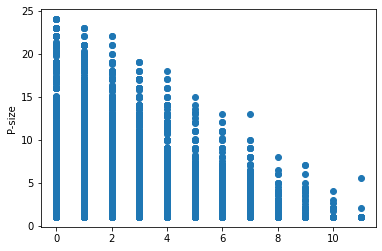

----
Feature: out_degree


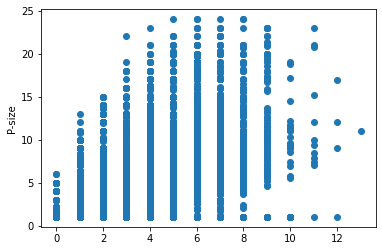

----
Feature: num_descendants


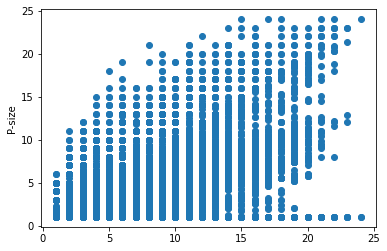

----
Feature: longest_descendant_path


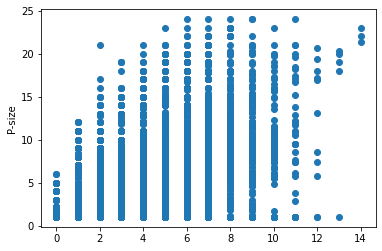

----


In [6]:
for col in df.columns:
    if col == 'psize':
        continue
    print('Feature: ' + col)
    plt.scatter(df[col], df.psize)
    plt.ylabel('P-size')
    plt.show()
    print('----')

In [7]:
import statsmodels.api as sm

X = df[['in_degree', 'out_degree', 'num_descendants', 'longest_descendant_path']]
X = sm.add_constant(X)
Y = df['psize']
model=sm.OLS(Y, X.astype(float)).fit()
predictions=model.predict(X)
print_model=model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  psize   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     2283.
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:56:43   Log-Likelihood:                -32069.
No. Observations:               12825   AIC:                         6.415e+04
Df Residuals:                   12820   BIC:                         6.419e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [ ]:
# number of dag
# position of 